In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Setting

In [3]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## Processing

<AxesSubplot:>

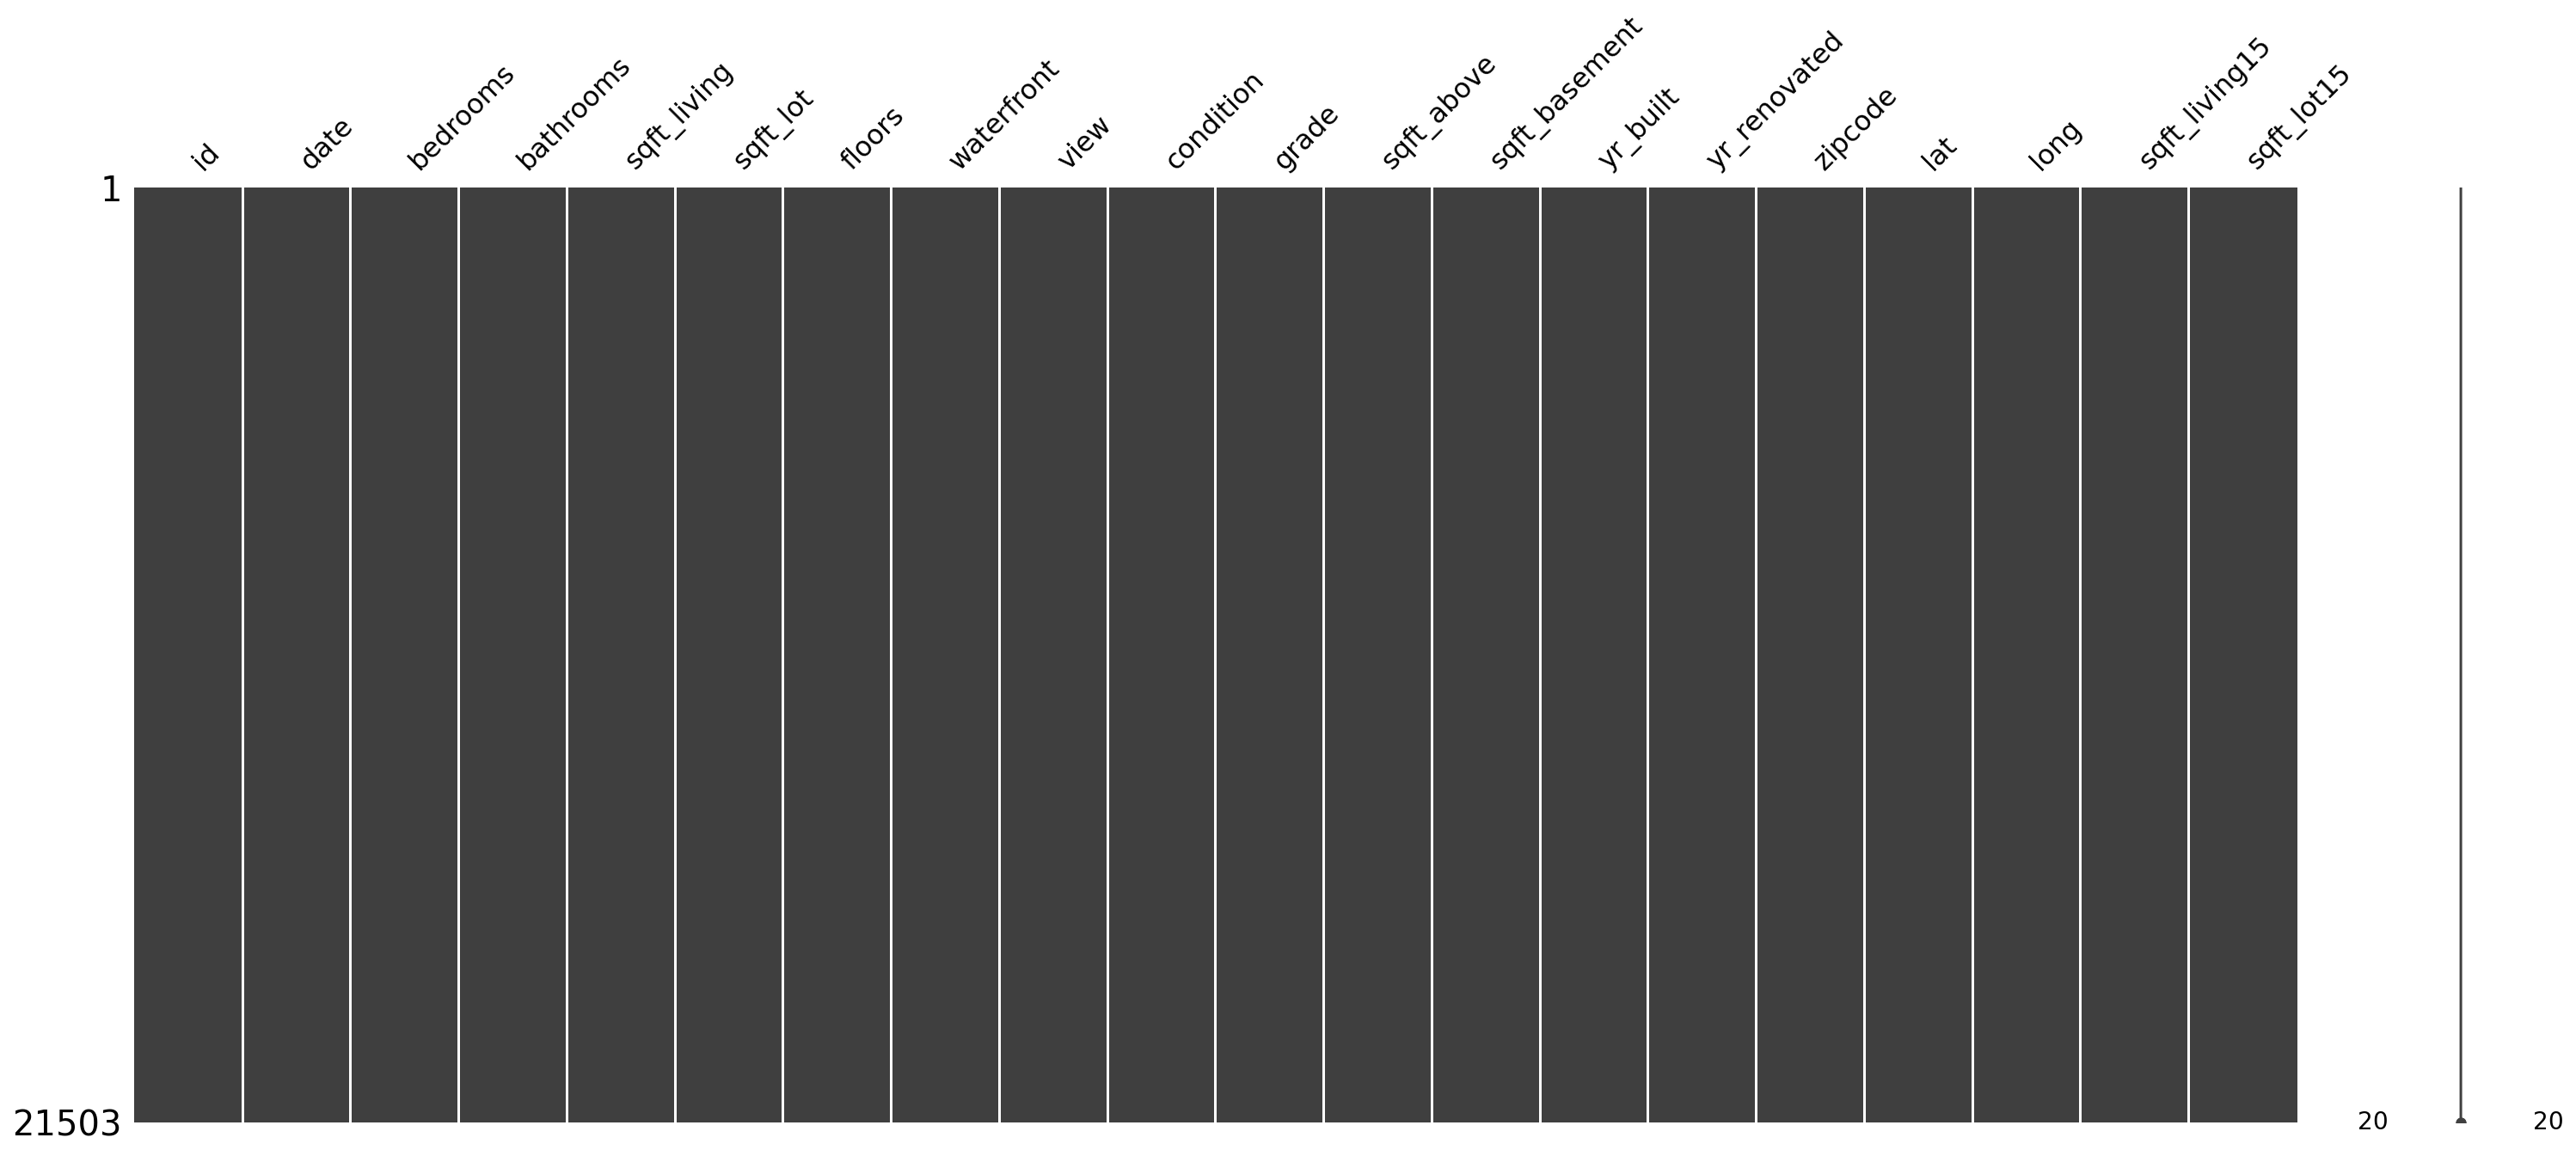

In [7]:
msno.matrix(data)

In [8]:
print("* 데이터 타입, 데이터프레임 정보 확인")
print("----------------------------------------------------------------------")
data.info()
print()
print("* 데이터 칼럼별 결측값 확인")
print("----------------------------------------------------------------------")
data.isnull().sum()

* 데이터 타입, 데이터프레임 정보 확인
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  l

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [9]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])

# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']


# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

# or

# print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id: 0


### feature selection

In [10]:
# id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.
# date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6]))

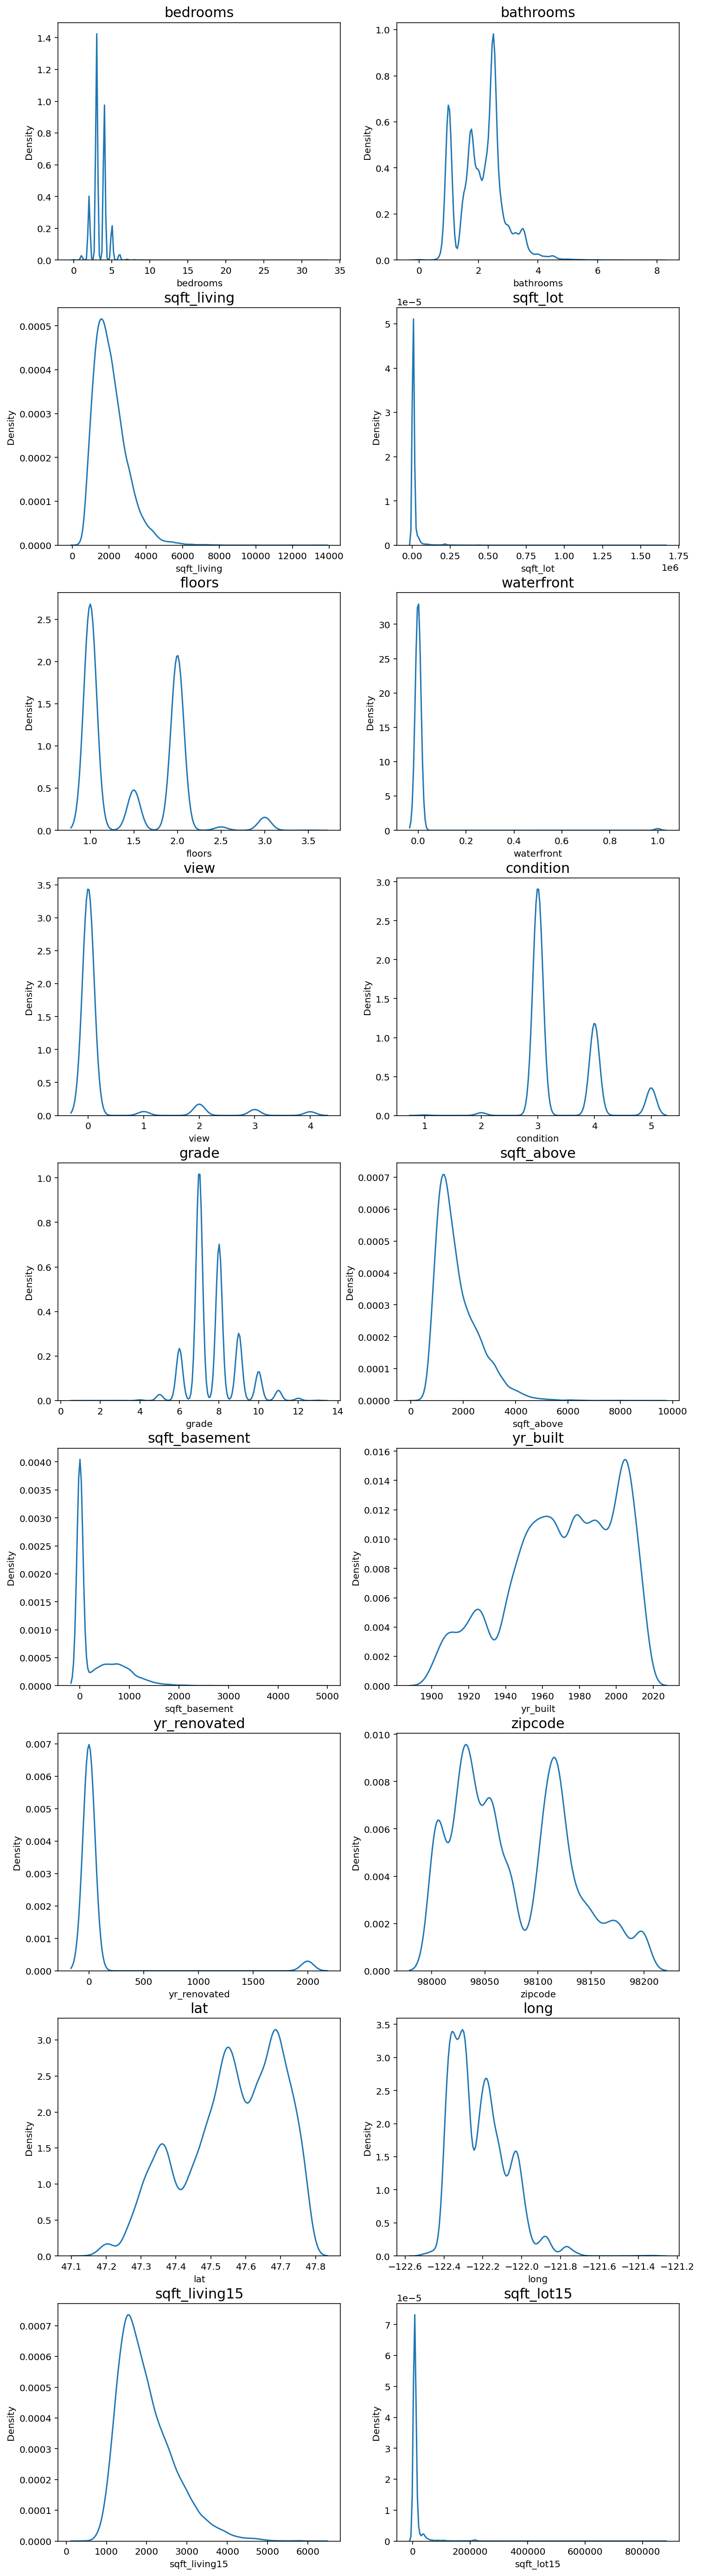

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


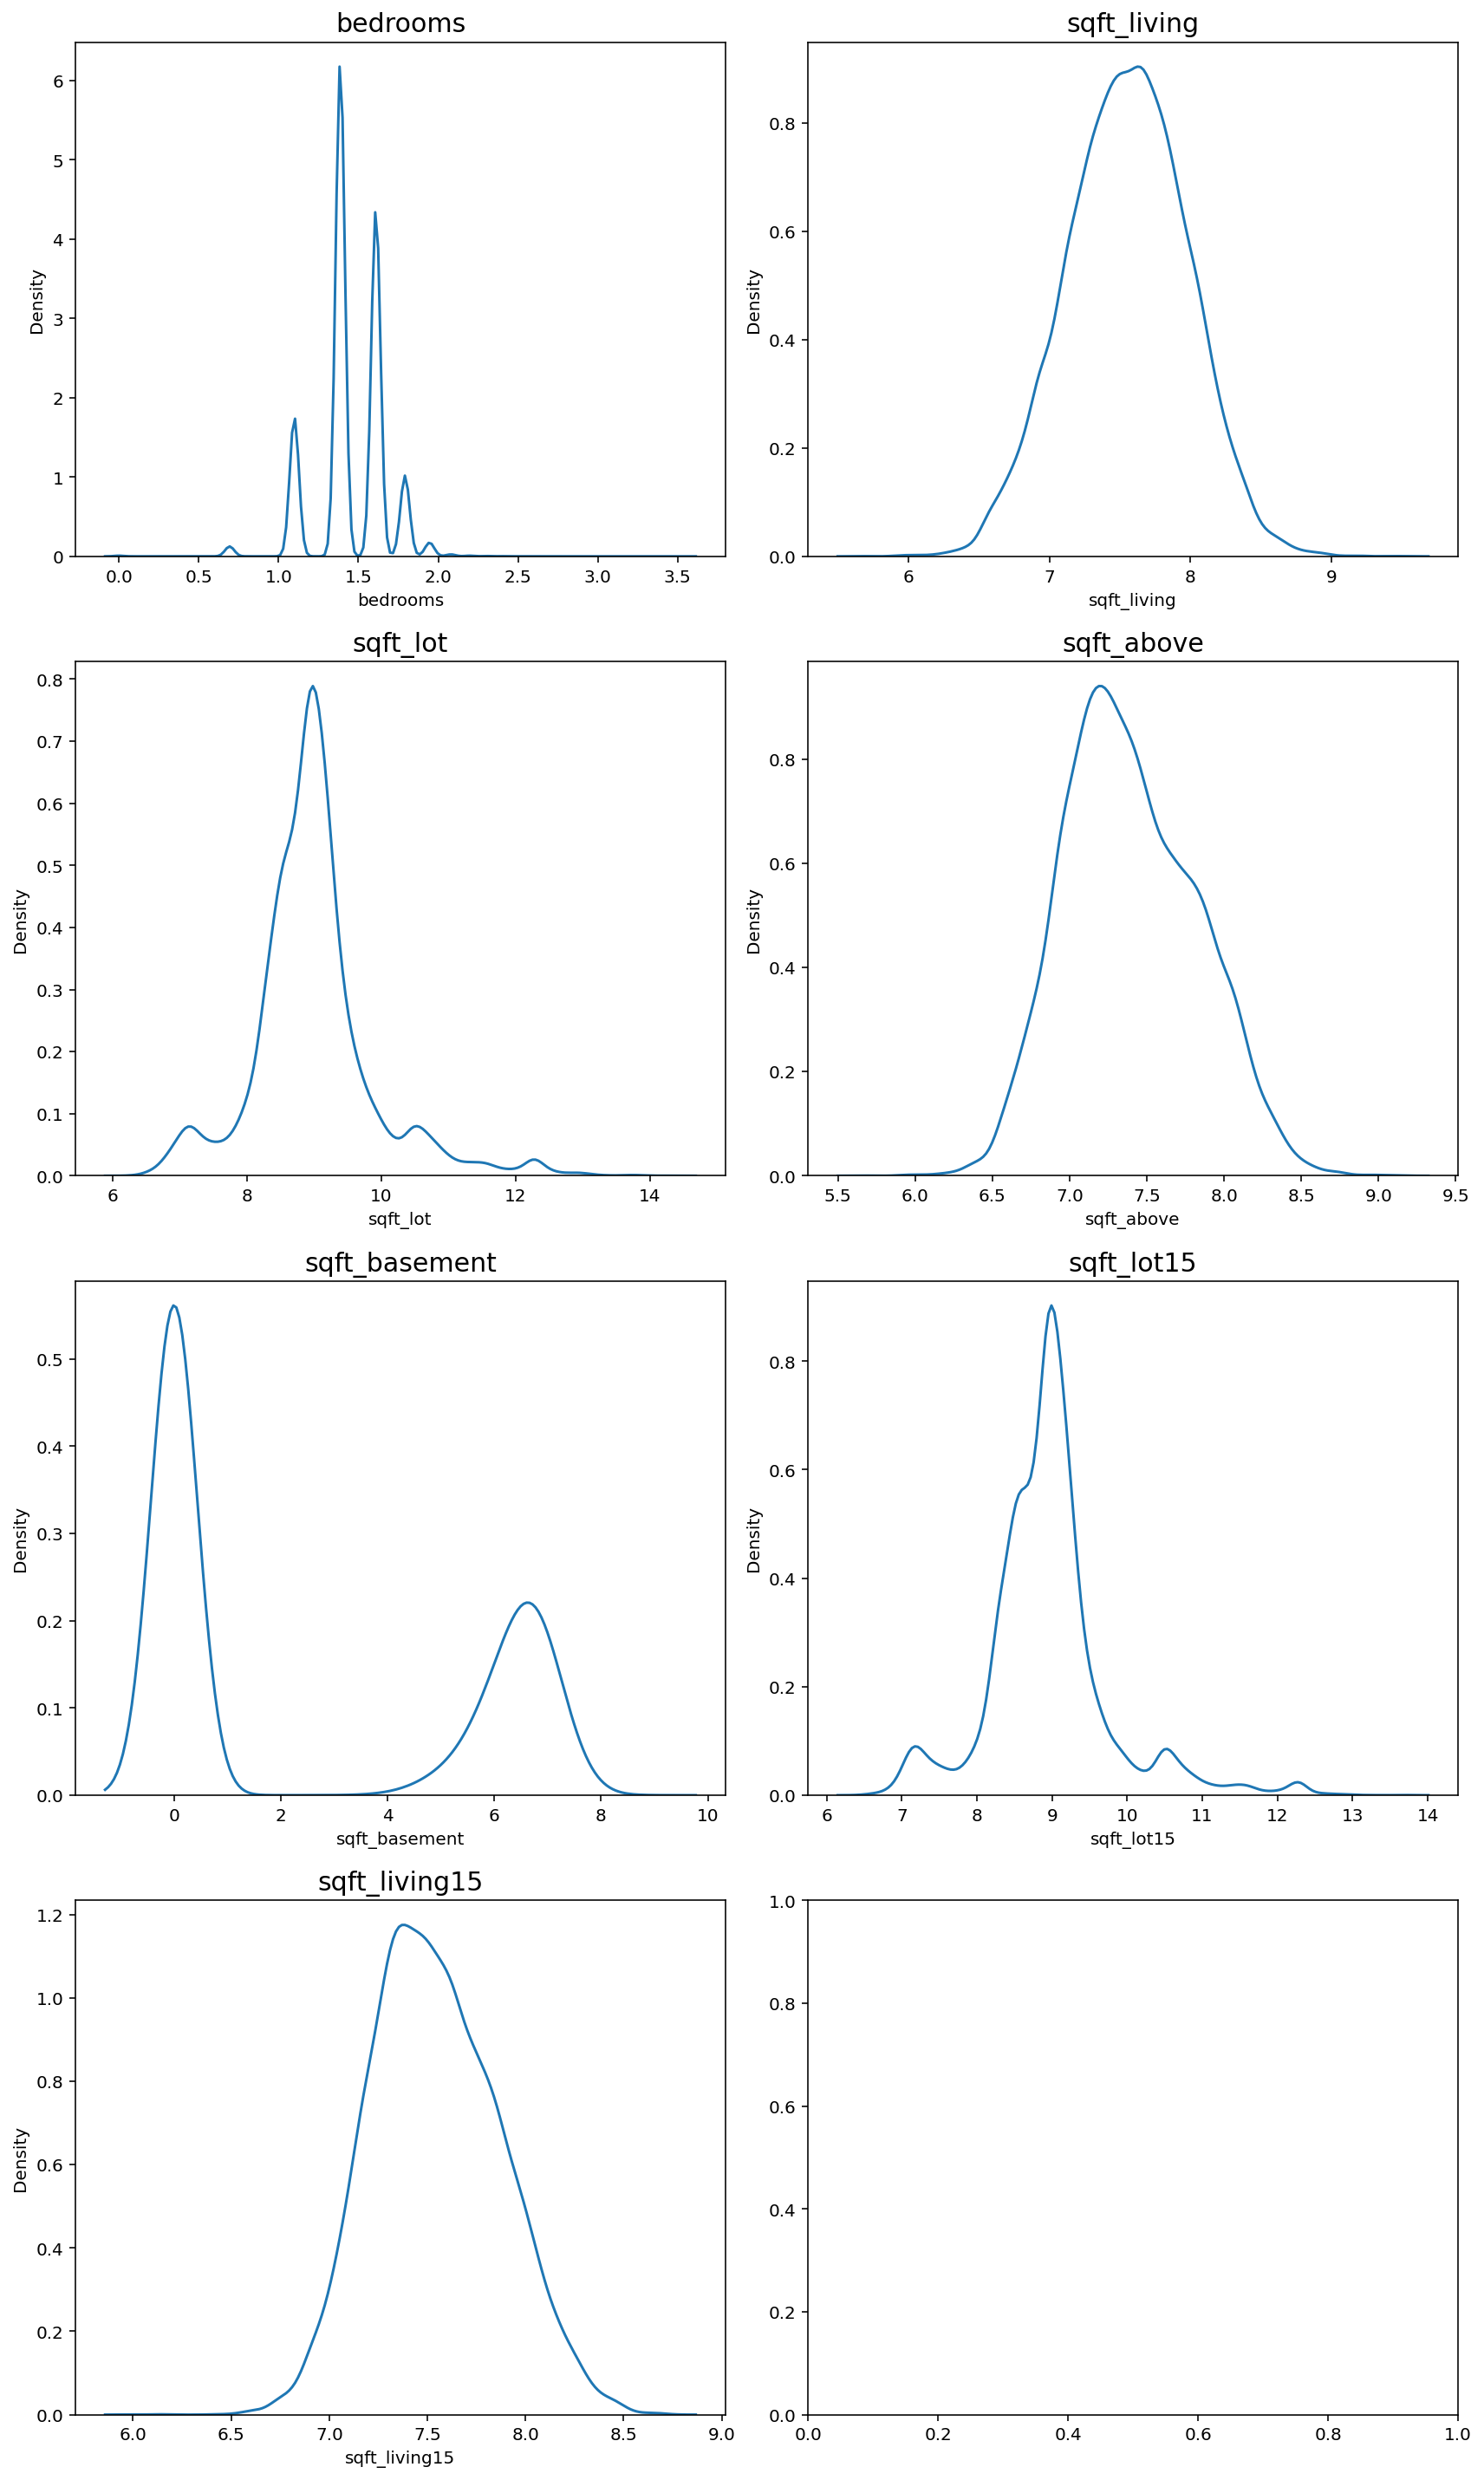

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

count = 0
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for row in range(4):
    for col in range(2):
        column = skew_columns[count]
        sns.kdeplot(data=data[column], ax=ax[row][col])
        ax[row][col].set_title(column, fontsize=15)
        count += 1
        if count == len(skew_columns):
            break

plt.tight_layout()
plt.show()


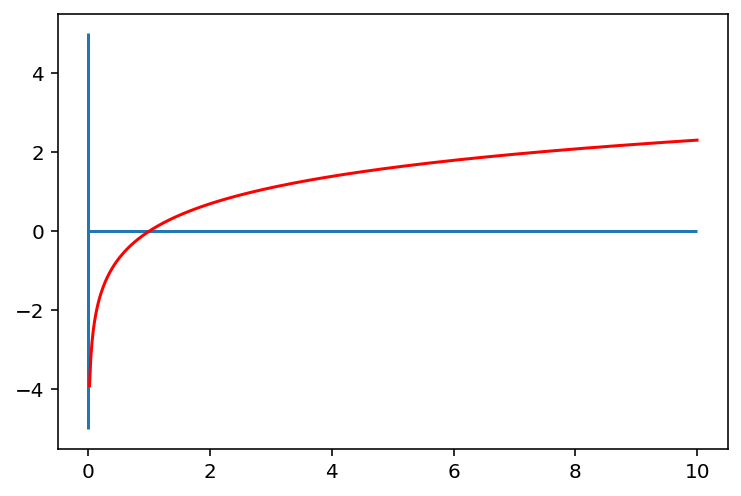

In [14]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

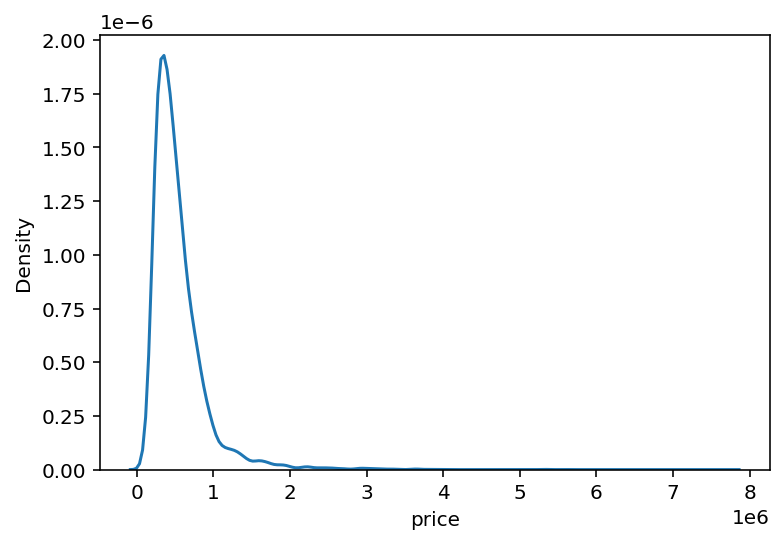

In [15]:
sns.kdeplot(y)
plt.show()

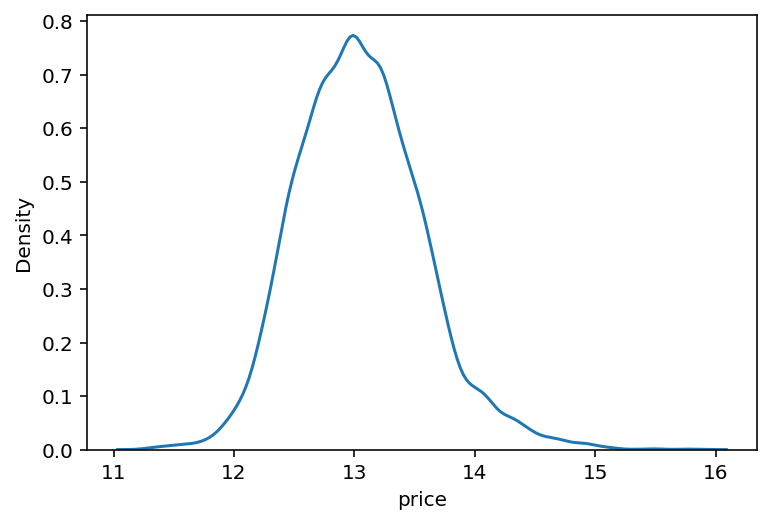

In [16]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

## Modeling

In [17]:
# 트테 분리

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [18]:
# Gboost
# XGboost
# LightGBM

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


## Cross validatoin

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)


Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


## Test

In [19]:
# evaluation metric

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [20]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

## Save submission csv

In [23]:
# submission 샘플 확인

data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
submission.shape

(6468, 2)

In [25]:
# 샘플과 같은 형태로 df형성
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [26]:
result.shape

(6468, 2)

In [29]:
# save submission file

my_submission_path = './submission/1st_baseline_submission.csv'

result.to_csv(my_submission_path, index=False)

print(my_submission_path)

./submission/1st_baseline_submission.csv
